In [2]:

import thermo_potentials as tp
pot = tp.load_potential('binary_2phase_elastic')

ModuleNotFoundError: No module named 'potentials'

In [1]:
from firedrake import *
from firedrake.petsc import PETSc

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [10]:
# Setup parameters
L = 1.0
N = 32
dt = 0.01
T = 0.5
nu = 0.01

# Define mesh and function space
mesh = UnitSquareMesh(N, N)
V_phi = FunctionSpace(mesh, "CG",1)
V_rho = FunctionSpace(mesh, "CG", 1)
V = MixedFunctionSpace([V_phi, V_rho])

In [11]:
# Define the coupled Allen-Cahn equations
u,v = TrialFunctions(V)
phi, psi = TestFunctions(V)

In [1]:
import random
from firedrake import *

# Class representing the intial conditions
# class InitialConditions(Expression):
#     def __init__(self):
#         random.seed(2 + MPI.process_number())
#     def eval(self, values, x):
#         values[0] = 0.63 + 0.02*(0.5 - random.random())
#         values[1] = 0.0
#     def value_shape(self):
#         return (2,)

# Class for interfacing with the Newton solver
class CahnHilliardEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
        self.reset_sparsity = True
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A, reset_sparsity=self.reset_sparsity)
        self.reset_sparsity = False

# Model parameters
lmbda  = 1.0e-02  # surface parameter
dt     = 5.0e-06  # time step
theta  = 0.5      # time stepping family, e.g. theta=1 -> backward Euler, theta=0.5 -> Crank-Nicolson

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["representation"] = "quadrature"

# Create mesh and define function spaces
mesh = UnitSquareMesh(96, 96)
V = FunctionSpace(mesh, "Lagrange", 1)
ME = V*V

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


NameError: name 'Expression' is not defined

In [2]:
from firedrake import *
from math import log, ceil
from firedrake.petsc import PETSc

def print(*args, **kwargs):
    #Overloads print to be the petsc routine which relegates to the head mpi rank
    PETSc.Sys.Print(*args,flush=True)

M_phi = 1e-3#1e-8
D = 1e-3 #m^2/s = .1 cm^2/s
interface_width = .1

x_scale = 1
c_scale = 1

Lx = 4
Ly = Lx/1
Lz = Lx/1


# Coarse mesh should have an 'appreciable' resolution. Fine mesh is scale of feature of interest
mesh_res_coarse = Lx/4
mesh_res_final = interface_width #target mesh resolution
mg_levels = ceil( log(mesh_res_coarse/mesh_res_final,2) )
print('Using {} levels of refinement'.format(mg_levels))

mesh = BoxMesh(round(Lx/mesh_res_coarse), round(Ly/mesh_res_coarse), round(Lz/mesh_res_coarse), Lx/x_scale, Ly/x_scale, Lz/x_scale, reorder=True)

hierarchy = MeshHierarchy(mesh, mg_levels)
mesh = hierarchy[-1]
# with File("mesh_mg.pvd") as of:
#     of.write(hierarchy[0])
outfile = File("mesh_mg.pvd")
outfile.write(hierarchy[0])
# outfile.write(*hierarchy)
#mesh = hierarchy[2]
#[outfile.write(mesh,time=i) for i,mesh in enumerate(hierarchy)]
# for i in range(len(hierarchy)):
#     print(i)
#     outfile.write(*hierarchy,time=i)
print('Mesh hierarchy assembled')

# utility function to help with non-dimensionalization
def gr(x):
    return grad(x)/x_scale



xmesh = SpatialCoordinate(mesh)
x = xmesh*x_scale

V_phase = FunctionSpace(mesh, "CG", 1, name="phases")
V_species = VectorFunctionSpace(mesh, "CG", 1, dim=2, name ="species")
V = MixedFunctionSpace([V_species, V_phase])

U = Function(V)
dU = TrialFunction(V)
test_U = TestFunction(V)
test_c, test_phase = split(test_U)

cmesh, phase = split(U)
c = c_scale*cmesh

# Phase field functions
p_phase = phase**3*(6*phase**2-15*phase+10)
g_phase = phase**2*(1-phase)**2
interface_area = 3*( interface_width**2*inner(gr(phase),gr(phase)) + g_phase)
interface_energy = 5000

ps = as_vector([p_phase, 1-p_phase])

# Load potential
pot = 1

response = pot.grad([c_scale*cmesh[0], c_scale*cmesh[1]]+[p_phase, 1-p_phase])   #Fixme - shouldn't be negative

mu = as_vector(response[:n])
P = as_vector(response[n:])
print('Thermodynamic driver forces loaded')

J =  -D*gr(mu)
F_diffusion = inner(J, gr(test_c))*dx
F_diffusion = 1/c_scale*F_diffusion

F_phase = -M_phi*inner(P, derivative(ps, phase, test_phase))*dx                         #bulk
F_phase += -M_phi*derivative(interface_energy*interface_area, phase, test_phase)*dx     #interfacial

F = F_diffusion + F_phase

params = {'snes_monitor': None,
          'snes_max_it': 10,
          'snes_atol':1e-6,
          'snes_rtol':1e-20,
          'snes_view': None,
          'ksp_converged_reason': None,
          #'snes_linesearch_type': 'bt',

          #Direct
          #'pc_type': 'lu', 'ksp_type': 'preonly', 'pc_factor_mat_solver_type': 'mumps',

          #Geometric multigrid
          'ksp_type':'fgmres', 'pc_type':'mg', 'mg_coarse_pc_type':'lu','mg_coarse_pc_factor_mat_solver_type':'mumps',
          }

# Since using a quadratic potential, we can just get initial values from expansion point
pt = pot.additional_fields['expansion_point']
print(pt)

ci_a = as_vector([pt['c0_a'], pt['c1_a']])/pt['V_a']
ci_b = as_vector([pt['c0_b'], pt['c1_b']])/pt['V_b']
print(ci_a)
print(ci_b)
# ci0 = as_vector([.2, .8])
# ci1 = as_vector([.8, .2])

# ~~~ Initial conditions ~~~ #
rc = 0*as_vector([1,1,1])
r = sqrt(inner(x-rc,x-rc))
#p0 = (.5*(1.-tanh((x[0]-.5*Lx)/(2.*interface_width))))# * (.5*(1.-tanh((3-x[0])/(2.*interface_width))))
p0 = (.5*(1.-tanh((r-.2*10)/(2.*interface_width))))# * (.5*(1.-tanh((3-x[0])/(2.*interface_width))))
#pp0 = p0**3*(6*p0**2-15*p0+10)

U.sub(1).interpolate(p0)

ic = p0*(1+0*1e-3)*ci_a+(1-p0)*ci_b
U.sub(0).interpolate(ic/c_scale)

# Boundary conditions
bcs = [
    DirichletBC(V.sub(1), Constant(0), 2),
    #DirichletBC(V.sub(0), ci1/c_scale, 2),
    #DirichletBC(V.sub(3),Constant([0,0,0]), boundaries),
    ]


# Set up time stepper

dt = Constant(5.0e-2)
t_end = 10000.0
t = Constant(0.0)

tm = as_vector([1, 1, 1])
stepper = timestepper(U, test_U, [F_diffusion, F_phase], [], tm, bcs=bcs, dt = dt, params=params)

field_names = ['c', 'ps', 'P', 'mu']#, 'ca', 'cb']
writer = writer([ 'cmesh', 'phase'], field_names,[eval(f) for f in field_names],mesh)
writer.write(U, 0.0)

iter_t = 0
eps_tol_t= 10
eps_tol_t_target = eps_tol_t/2

phase_old = Function(V_phase)

while float(t) < t_end and iter_t<10:

    iter_t +=1
    phase_old.assign(U.sub(1))
    print('')

    print('{:n}: Time: {:6.4g}'.format(iter_t, float(t+dt)))
    try:
        so, eps_t, maxdt = stepper.step(dt)
        # If time step successful
        print('Succeeded. Estimated error: {:4.2g}, max change {:4.2g}'.format(eps_t, maxdt))
    except KeyboardInterrupt:
        print ('KeyboardInterrupt exception is caught')
        break

    except Exception as ex:
        # Time stepper failed. Retry with smaller timestep
        #raise
        print('failed')
        print(ex)
        dt.assign(float(dt)*.5)
        stepper.reset_step()
        continue

    # Time step was successful and has been accepted
    t.assign(float(t)+float(dt))
    stepper.accept_step()
    stepper.solver.parameters.pop('snes_view',None) # Unset the snes_viewer so as not to repeat it.
    # Adapt the time step to some metric
    dphase = errornorm(phase,phase_old,'l10')
    print('max phase change', dphase)
    dphase_target = .1
    #dt.assign(float(dt)*min( (eps_tol_t_target/(eps_t+1e-10)), 5))  # Change timestep to aim for tolerance
    dt.assign(float(dt)*min( (dphase_target/(dphase)), 20))  # Change timestep to aim for tolerance

    if iter_t %1 ==0:
        writer.write(U, time=float(t))

Using 4 levels of refinement
Mesh hierarchy assembled


AttributeError: 'int' object has no attribute 'grad'

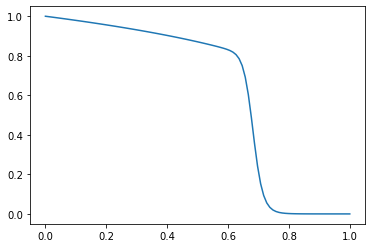

In [11]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0,1,100)
y =  1/(1+2.71**(-2.0*50.0*((x-1)**2 -0.1)))*(((x-1)**2)**(0.1))
y = y
plt.plot(x,y)

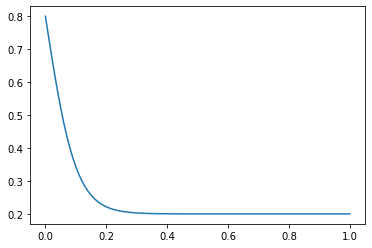

In [29]:
y =((0.8 - 0.2)*(1.-np.tanh((x)/(2.*0.05))) )+ 0.2
plt.plot(x,y)